In [4]:
# import system modules
import sys
import os
import gc

# import standard numerical modules
import numpy as np
import math

import matplotlib.pyplot as plt

# import machine learning modules
import tensorflow as tf
import keras.backend as K

sys.path.append('../20240503')
import DCTR


In [6]:
def get_wgt_from_lhe(lhe_file, limit = None):
    # Use Madgraph EventFile
    from madgraph.various.lhe_parser import EventFile # madgraph EventFile for getting event weights from lhe

    # get event weights from lhe file
    wgt = []
    lhe = EventFile(lhe_file) # uses madgraphs EventFile function to open the lhe file
    if limit is None:
        limit = len(lhe)
    for i, event in enumerate(lhe):
        if i >= limit:
            break
        w = event.wgt
        wgt.append(w)
    
    return wgt


In [7]:
from madgraph.various.lhe_parser import EventFile # madgraph EventFile for getting event weights from lhe

def convert_valentinas_datasets_to_mine(tt_npz_list, top_npz_list, lhe_list, theta):
    '''converts valentinas dataset layout and shape into mine.
    valentinas: tt:  [pt, y, eta, phi, mass, E]
                top: [pt, y, eta, phi, mass, PID]
    mine:            [pt, y, phi, mass, eta, E, PID, w, theta]
                     [0 , 1, 2  , 3   , 4  , 5, 6  , 7, 8    ]

    args:
        tt_npz_list

    no event weights! We need to load lhe to find event weight.
    '''
    assert len(tt_npz_list) == len(top_npz_list) == len(lhe_list), 'Lengths of lists must be equal!'

    # create mapping from valentinas to mine
    target_order  = ['pt', 'y', 'phi', 'mass', 'eta', 'E', 'PID', 'w', 'theta'] # my order
    org_order_tt  = ['pt', 'y', 'eta', 'phi', 'mass', 'E', 'PID', 'w', 'theta'] # tt org
    org_order_top = ['pt', 'y', 'eta', 'phi', 'mass', 'PID', 'E', 'w', 'theta'] # top org
    mapping_tt = [org_order_tt.index(col) for col in target_order]
    mapping_top = [org_order_top.index(col) for col in target_order]
    
    out = []
    skipped = []
    for i, _ in enumerate(tt_npz_list):
        # check if files exist
        if not os.path.exists(tt_npz_list[i]):
            print(f"file: {tt_npz_list[i]} doesn't exist; skipping")
            skipped.append(i+1)
            continue
        elif not os.path.exists(top_npz_list[i]):
            print(f"file: {top_npz_list[i]} doesn't exist; skipping")
            skipped.append(i+1)
            continue
        elif not os.path.exists(lhe_list[i]):
            print(f"file: {lhe_list[i]} doesn't exist; skipping")
            skipped.append(i+1)
            continue
        
        # get event weights from lhe file
        wgt = []
        lhe = EventFile(lhe_list[i]) # uses madgraphs EventFile function to open the lhe file
        for event in lhe:
            w = event.wgt
            wgt.append(w)
        # print(f'{np.shape(wgt) = }')
        
        # load tt-dataset
        tt = []
        tt = np.load(tt_npz_list[i])['a']
        # print(f'{np.shape(tt) = }')
        
        # load top (and anti-top) dataset
        top = []
        top = np.load(top_npz_list[i])['a']
        # print(f'{np.shape(top) = }')

        # check that lhe file and converted npz contain same number of events
        if len(tt) != len(wgt) != len(top):
            print(f'different number of events in files! \n' + 
                  f'tt : len: {len(tt)} | file: {tt_npz_list[i]} \n' +
                  f'top: len: {len(top)} | file: {top_npz_list[i]} \n' +
                  f'lhe: len: {len(wgt)} | file: {lhe_list[i]} \n' +
                  f'skipping files {i+1}')
            skipped.append(i+1)
            continue
        elif len(wgt) <= 10:
            print(f'file: {lhe_list[i]} only has {len(wgt)} events; skipping')
            skipped.append(i+1)
            continue
        

        # pad arrays into correct final shape
        tt = np.pad(tt, [(0,0), (0,0), (0, 3)])
        top = np.pad(top, [(0,0), (0,0), (0, 3)])   
        # print(f'shape after padding {np.shape(tt) = }')
        # print(f'shape after padding {np.shape(top) = }') 

        # re-sort datasets
        tt = tt[..., mapping_tt] 
        top = top[..., mapping_top]

        # concat to have tt-pair and top and anti-top for each event
        concat = []
        concat = np.concatenate((tt, top), axis=1)
        # print(f'{np.shape(concat) = }')
        
        # add wgt
        wgt = [wgt] * 3 # every particle has same wgt (as it is an event wgt)
        concat[..., 7] = np.transpose(wgt)
        
        # add theta
        theta_ = np.full_like(concat[..., 8], theta)
        concat[..., 8] = theta_
        
        # add to out
        if i == 0:
            out = concat
        else:
            out = np.concatenate((out, concat), axis = 0)
        print(f'finished processing file {i+1:0>4}', end='\r')
    
    return out, skipped


# Process Data

In [ ]:
# X0 hvq
'''
X0_tt_npz_list  = ['/tf/data/BachelorThesis_Data/showered/hvq/ShowerTT_100.npz']
X0_top_npz_list = ['/tf/data/BachelorThesis_Data/showered/hvq/ShowerTop_100.npz']
X0_lhe_list     = ['/tf/data/BachelorThesis_Data/LHE/data/POWHEG_new/Results100/pwgevents.lhe']
X0_theta = 0

X0_showered, _ = convert_valentinas_datasets_to_mine(X0_tt_npz_list, X0_top_npz_list, X0_lhe_list, theta = X0_theta)

print(np.shape(X0_showered))
'''

In [ ]:
# normalize data
'''
data_dir = '../Data'

# nrm_array from previous normalization (of showered events)
nrm_array = np.load(f'{data_dir}/POWHEG_hvq/showered/norm_array_lhe_01.npy')

# normalize data
X0_nrm, _ = DCTR.normalize_data(X0_showered.copy(), nrm_array)
print('X0 normalized')

# save normalized and unnormalized
np.save(f'{data_dir}/Jets/hvq_Results100_showered_normed_lhe.npy', X0_nrm)
np.save(f'{data_dir}/Jets/hvq_Results100_showered_converted_lhe.npy', X0_showered)
'''

In [ ]:
# X1 MiNNLO
'''
X1_tt_npz_list  = ['/tf/data/BachelorThesis_Data/showered/MiNNLO/ShowerTTR_1000_0.855.npz']
X1_top_npz_list = ['/tf/data/BachelorThesis_Data/showered/MiNNLO/ShowerTopR_1000_0.855.npz']
X1_lhe_list     = ['/tf/data/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-1000.lhe']
X1_theta = 1

X1_showered, _ = convert_valentinas_datasets_to_mine(X1_tt_npz_list, X1_top_npz_list, X1_lhe_list, theta = X1_theta)

print(np.shape(X1_showered))
'''

In [ ]:
# normalize data
'''
X1_nrm, _ = DCTR.normalize_data(X1_showered.copy(), nrm_array)
print('X1 normalized')

# save normalized and unnormalized
np.save(f'{data_dir}/Jets/MiNNLO_Results1000_R_0.855_showered_normed_lhe.npy', X1_nrm)
np.save(f'{data_dir}/Jets/MiNNLO_Results1000_R_0.855_showered_converted_lhe.npy', X1_showered)
'''

In [50]:
# load datasets created in commented out cells above ^
# and n-jettiness datasets created with python scripts on NAF
data_dir = '../Data'
num_events = 100000


X0_showered = np.load(f'{data_dir}/POWHEG_hvq/dileptonic/converted_lhe.npy')[:num_events]
X0_nrm = np.load(f'{data_dir}/POWHEG_hvq/dileptonic/normed_lhe.npy')[:num_events]
X0_nJets = np.load(f'{data_dir}/Jets/jet_multiplicity_hvq_dileptonic.npy')[:num_events]
X0_wgt = X0_showered[:,0,-2]


print(f'{np.shape(X0_showered)  = }')
print(f'{np.shape(X0_nrm)       = }')
print(f'{np.shape(X0_nJets)     = }')
print(f'{np.shape(X0_wgt)       = }')


np.shape(X0_showered)  = (100000, 3, 9)
np.shape(X0_nrm)       = (100000, 3, 9)
np.shape(X0_nJets)     = (100000,)
np.shape(X0_wgt)       = (100000,)


In [49]:
# MiNNLO 

# X1_showered = np.load(f'{data_dir}/MiNNLO/showered/converted_lhe.npy')[:num_events]
# X1_nrm = np.load(f'{data_dir}/MiNNLO/showered/normed_lhe.npy')[:num_events]

X1_nJets = []
for i in range(11):
    X1_nJets.extend(np.load(f'{data_dir}/Jets/jet_multiplicity_MiNNLO_{990 + i:04d}.npy'))
X1_nJets = np.array(X1_nJets)[:num_events]

# X1_wgt = X1_showered[:,0,-2] # incorrect weights, not related to njets

# print(f'{np.shape(X1_showered)  = }')
# print(f'{np.shape(X1_nrm)       = }')
print(f'{np.shape(X1_nJets)     = }')
# print(f'{np.shape(X1_wgt)       = }')


np.shape(X1_nJets)     = (100000,)


In [66]:
lhe_list_MiNNLO = []

lhe_dir = '/home/finn/Documents/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000'
num_events = 100000

for i in range(11):
    lhe_list_MiNNLO.extend([f'{lhe_dir}/pwgevents-{990 + i:04d}.lhe'])

print(lhe_list_MiNNLO)
X1_wgt = []

X1_wgt = []
for i, event_file in enumerate(lhe_list_MiNNLO):
    
    # get event weights from lhe file
    lhe = EventFile(event_file) # uses madgraphs EventFile function to open the lhe file
    for event in lhe:
        w = [event.wgt]
        # print(w)
        X1_wgt.extend(w)


X1_wgt = np.array(X1_wgt)[:num_events]

print(np.shape(X1_wgt))



['/home/finn/Documents/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-0990.lhe', '/home/finn/Documents/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-0991.lhe', '/home/finn/Documents/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-0992.lhe', '/home/finn/Documents/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-0993.lhe', '/home/finn/Documents/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-0994.lhe', '/home/finn/Documents/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-0995.lhe', '/home/finn/Documents/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-0996.lhe', '/home/finn/Documents/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-0997.lhe', '/home/finn/Documents/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-0998.lhe', '/home/finn/Documents/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-0999.lhe', '/home/finn/Documents/BachelorThesis_Data/LHE/data/MiNNLO/0501-1000/pwgevents-1000.lhe']
(100000,)


In [62]:
print(f'{(X0_nJets[:20])     = }')
# print(f'{(X0_nJets_old[:20]) = }')
print(f'{(X1_nJets[:20])     = }')
# print(f'{(X1_nJets_old[:20]) = }')

print(f'{max(X0_nJets)     = }')
# print(f'{max(X0_nJets_old) = }')
print(f'{max(X1_nJets)     = }')
# print(f'{max(X1_nJets_old) = }')


(X0_nJets[:20])     = array([4, 4, 2, 2, 4, 3, 4, 3, 3, 4, 4, 5, 5, 5, 3, 3, 6, 4, 2, 5])
(X1_nJets[:20])     = array([3, 2, 5, 1, 3, 3, 2, 5, 1, 3, 2, 3, 3, 6, 3, 5, 5, 3, 5, 4])
max(X0_nJets)     = 13
max(X1_nJets)     = 16


In [52]:
# delete energy from (normalized) testing dataset, since the neural network was trained without these parameters
X0_nrm = np.delete(X0_nrm, 5, -1) # E
X0_nrm = np.delete(X0_nrm, 4, -1) # eta
# garbage collection after deleting to clear memory asap
print(gc.collect())


2015


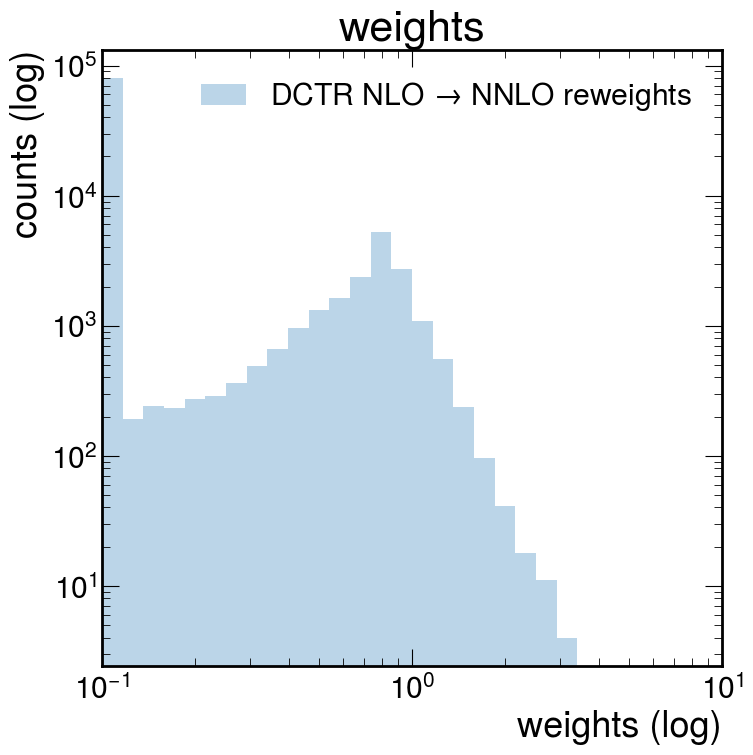

In [63]:
# get rwgt and compare hvq before and after rwgt


# calculate weights from DCTR
model = '../20240521_showered_new/train_20240522/super_epoch_6/run_0/s-6_b-131072_r-0.tf' # path to previously trained model (in .tf format (folder)) for showered events


# calculate rwgt
with tf.device('CPU'):
    dctr_rwgt = DCTR.get_rwgt([model], X0_nrm) # .tf models also include network architecture. get_rwgt() sets up the network for the (list of) models, then calls predict_weights() like in DCTR_notebook_OLD_14-to-13TeV notebook
# plot and check dctr rwgt
wgts = [(dctr_rwgt[0], r'DCTR NLO $\to$ NNLO reweights')]
DCTR.plot_weights(wgts, start = 0.1, stop = 10)

# apply orginal generator weights to rwgt
rwgt = np.multiply(dctr_rwgt[0], X0_wgt)


In [64]:
print(np.shape(X1_nJets))
print(np.shape(X1_wgt))

print(np.shape(X0_nJets))
print(np.shape(X0_wgt))

print(np.shape(rwgt))

(100000,)
(100000,)
(100000,)
(100000,)
(100000,)


/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/../20240503/DCTR.py:1393: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = hist0 / hist0
/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/../20240503/DCTR.py:1394: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = hist1 / hist0
/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/../20240503/DCTR.py:1395: RuntimeWarning: invalid value encountered in true_divide
  ratio_2 = hist2 / hist0
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


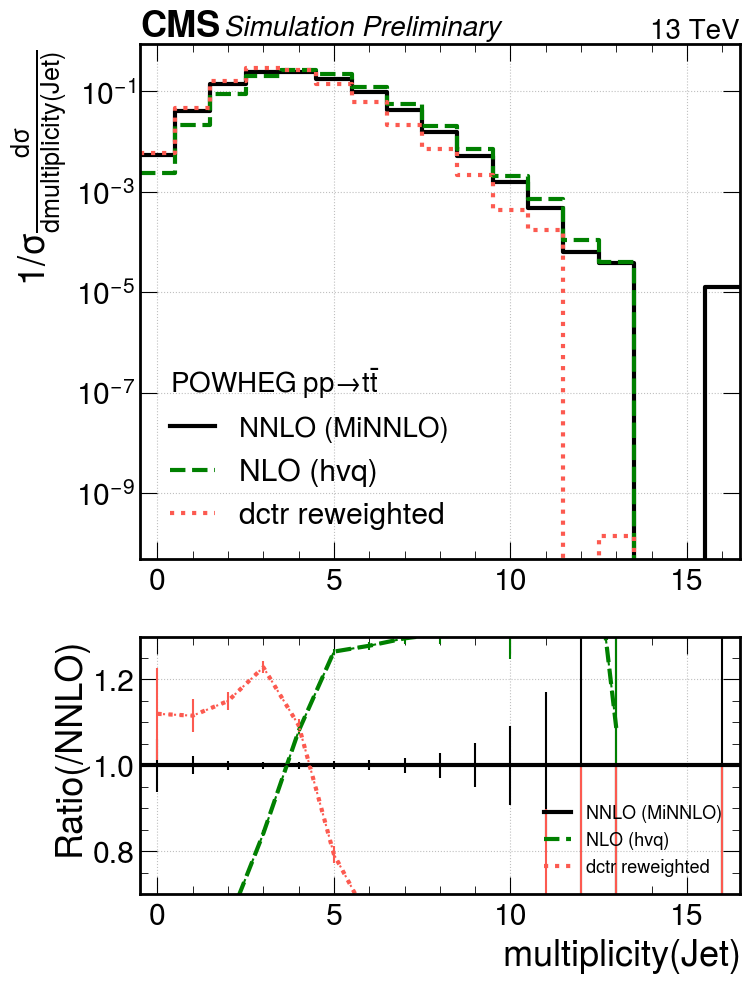

In [71]:
args_multiplicity = [(X1_nJets, X1_wgt, 'NNLO (MiNNLO)'),
                     (X0_nJets, X0_wgt, 'NLO (hvq)'),
                     (X0_nJets, rwgt, 'dctr reweighted')]


bins = np.linspace(-0.5, 16.5, 18)

DCTR.plot_ratio_cms(args_multiplicity, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


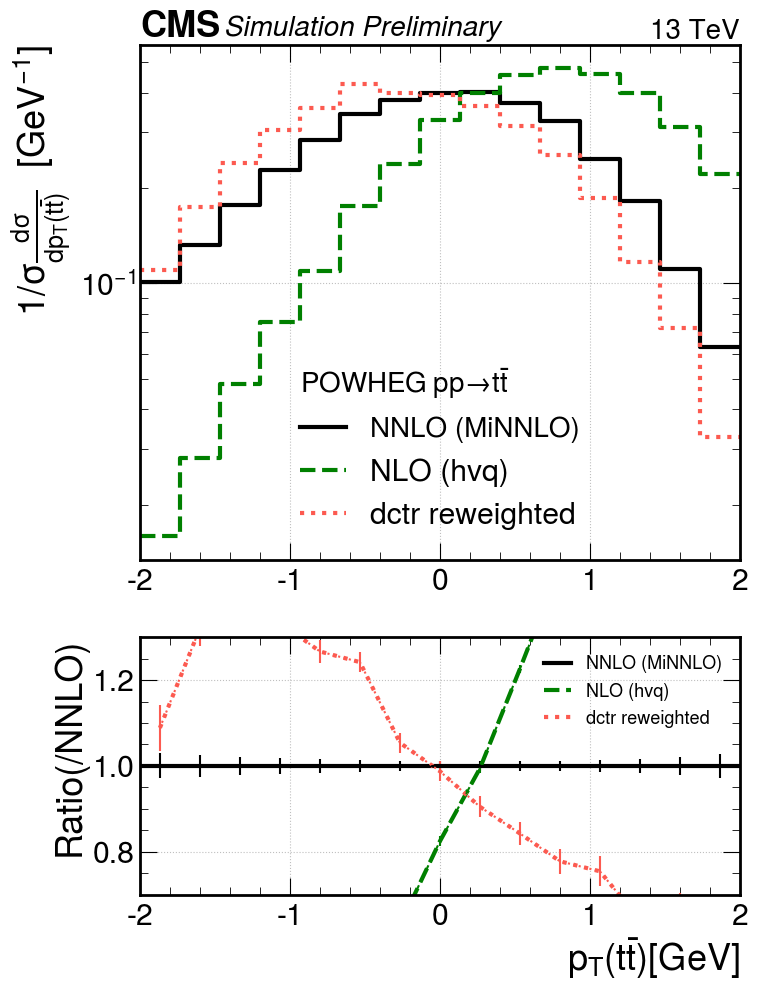

In [ ]:
args_test = [(X1_nrm, X1_wgt, 'NNLO (MiNNLO)'),
                     (X0_nrm, X0_wgt, 'NLO (hvq)'),
                     (X0_nrm, rwgt, 'dctr reweighted')]


bins = np.linspace(-2, 2, 16)

DCTR.plot_ratio_cms(args_test, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3]) #, part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')




/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/../20240503/DCTR.py:1781: RuntimeWarning: invalid value encountered in true_divide
  ratio_0 = hist0 / hist0
/home/finn/gdrive/_STUDIUM_/DCTR_Paper/git/DCTR_FP/20240521_showered_new/../20240503/DCTR.py:1782: RuntimeWarning: invalid value encountered in true_divide
  ratio_1 = hist1 / hist0
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


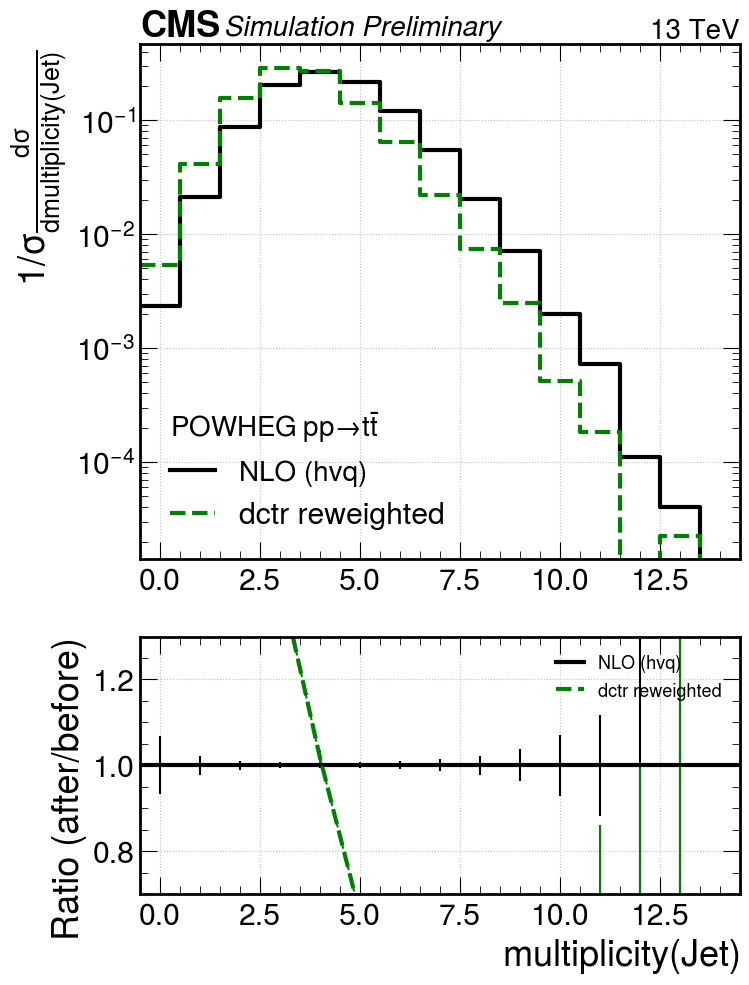

In [17]:
args_hvq = [(X0_nJets, X0_wgt, 'NLO (hvq)'),
            (X0_nJets, rwgt, 'dctr reweighted')]


bins = np.linspace(-0.5, 14.5, 16)

DCTR.plot_ratio_cms_2(args_hvq, bins = bins, y_scale = 'log', ratio_ylim=[0.7, 1.3], part_label='Jet', arg_label='multiplicity', unit='', inv_unit='')


In [16]:
X0_jet = np.load(f'{data_dir}/Jets/jet_4vectors_hvq_dileptonic.npy')[:num_events]
X1_jet = []
for i in range(11):
    X1_jet.extend(np.load(f'{data_dir}/Jets/jet_4vectors_MiNNLO_{990 + i:04d}.npy'))

X1_jet = np.array(X1_jet)[:num_events]

print(f'{np.shape(X0_jet) = }')
print(f'{np.shape(X1_jet) = }')



np.shape(X0_jet) = (100000, 20, 6)
np.shape(X1_jet) = (100000, 20, 6)


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


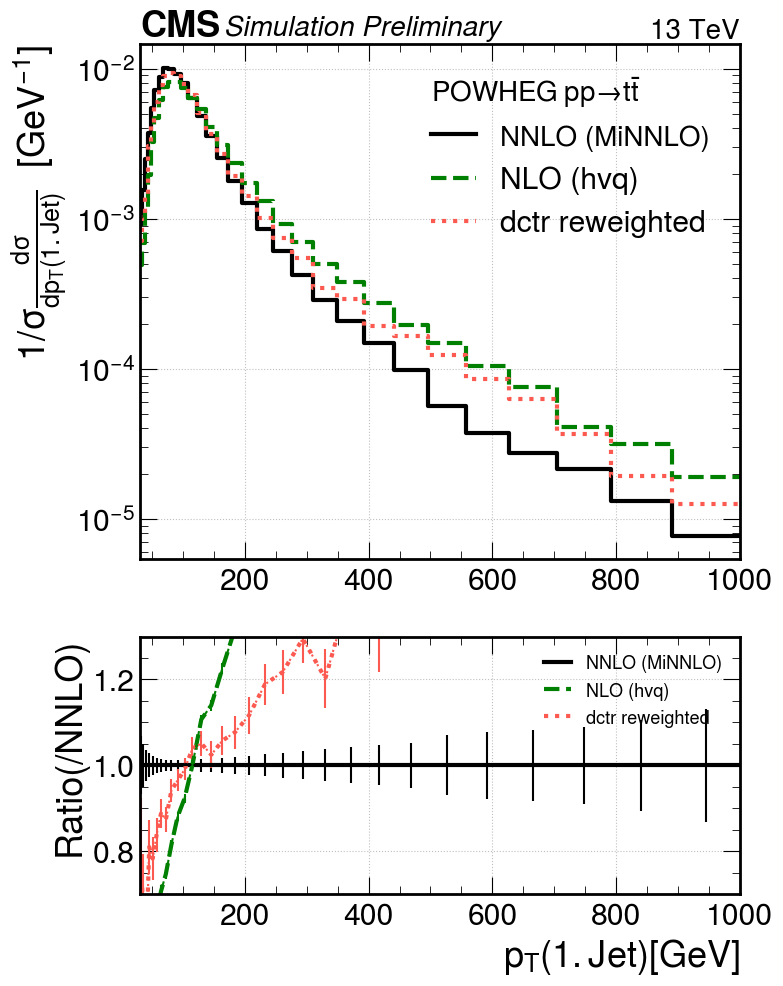

In [20]:
log_bins = np.logspace(np.log10(30), np.log10(1000), 31)

args_jet_0 = [(X1_jet[:, 0, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 0, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 0, 0], rwgt, 'dctr reweighted')]

DCTR.plot_ratio_cms(args_jet_0, bins = log_bins, y_scale = 'log', part_label='1. Jet', ratio_ylim=(0.7, 1.3))


args_jet_1 = [(X1_jet[:, 1, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 1, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 1, 0], rwgt, 'dctr reweighted')]

# DCTR.plot_ratio_cms(args_jet_1, bins = log_bins, y_scale = 'log', part_label='2. Jet')


args_jet_2 = [(X1_jet[:, 2, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 2, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 2, 0], rwgt, 'dctr reweighted')]

# DCTR.plot_ratio_cms(args_jet_2, bins = log_bins, y_scale = 'log', part_label='3. Jet')


args_jet_3 = [(X1_jet[:, 3, 0], X1_wgt, 'NNLO (MiNNLO)'),
              (X0_jet[:, 3, 0], X0_wgt, 'NLO (hvq)'),
              (X0_jet[:, 3, 0], rwgt, 'dctr reweighted')]

# DCTR.plot_ratio_cms(args_jet_3, bins = log_bins, y_scale = 'log', part_label='4. Jet')


np.shape(X0_jet_pt_sums) = (100000,)
np.shape(X1_jet_pt_sums) = (100000,)


'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


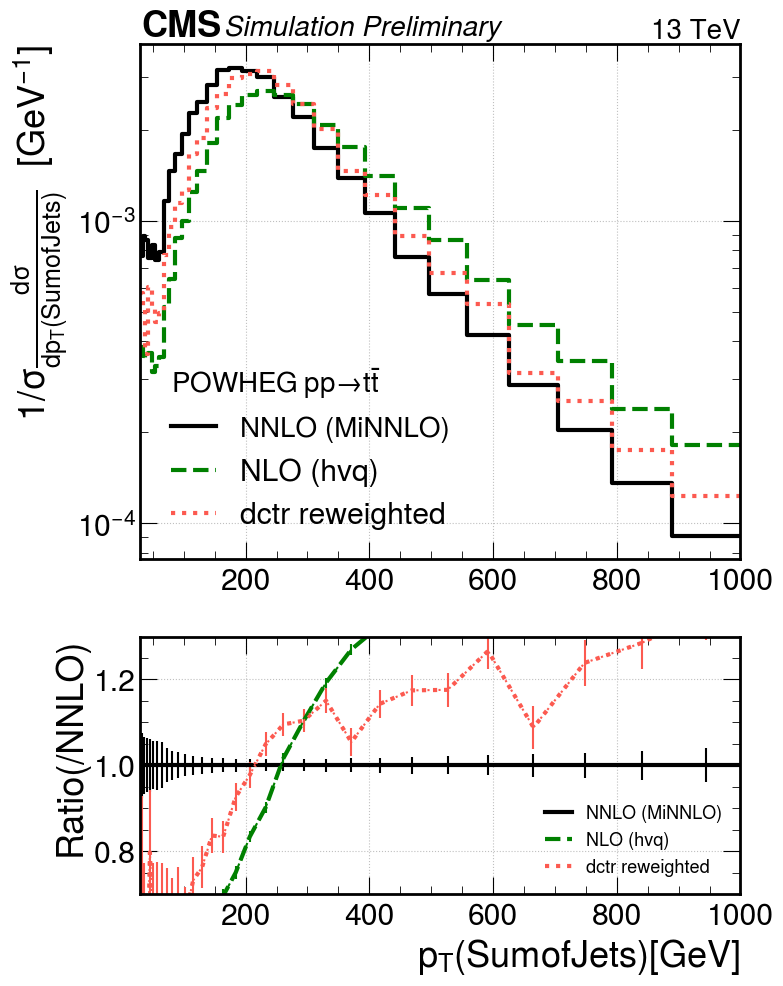

In [19]:
# sum of jet pt per event

X0_jet_pt_sums = []
for event in X0_jet:
    X0_jet_pt_sums.append(np.sum(event[:,0]))

X1_jet_pt_sums = []
for event in X1_jet:
    X1_jet_pt_sums.append(np.sum(event[:,0]))

    
print(f'{np.shape(X0_jet_pt_sums) = }')
print(f'{np.shape(X1_jet_pt_sums) = }')

log_bins = np.logspace(np.log10(10), np.log10(1000), 31)

args_jet_sum = [(np.array(X1_jet_pt_sums), X1_wgt, 'NNLO (MiNNLO)'),
                (np.array(X0_jet_pt_sums), X0_wgt, 'NLO (hvq)'),
                (np.array(X0_jet_pt_sums), rwgt, 'dctr reweighted')]

log_bins = np.logspace(np.log10(30), np.log10(1000), 31)

DCTR.plot_ratio_cms(args_jet_sum, bins = log_bins, y_scale = 'log', part_label='Sum of Jets', ratio_ylim=(0.7, 1.3))


